# WLS-EV Analysis

## Data Preprocessing

### Read in log return data and variance

In [1]:
"""
KIT CRAM Seminar WS17/18
Algorithmic Design - Least squares estimates weighted by ex-ante return variance (WLS-EV)
"""

__author__ = 'Tobias Kuhlmann'

# Import own libraries
from variance_estimation import ExAnteVariance
from wlsev_model import Wlsev_model
from ols_model import OLS_model
from simon_ols_model import OLS
# import general packages
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')


/Users/tobias/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Log return data

In [2]:
# Import price data and calc log returns
# --------------------------------------------------
es_50_prices = pd.read_csv('data/es50_prices.csv', parse_dates=True)
# Delete unnecessary columns
del es_50_prices['openprice']
del es_50_prices['highprice']
del es_50_prices['lowprice']
del es_50_prices['volume']
del es_50_prices['instrumentid']
# set index, rename and check
es_50_prices = es_50_prices.rename(columns={'loctimestamp': 'date'})
es_50_prices = es_50_prices.set_index('date')

#Log Returns
es_50_logret = es_50_prices
es_50_logret['logreturns'] = np.log(es_50_prices['lastprice'] / es_50_prices['lastprice'].shift(1))

### Volatility data

In [3]:
# Import vol data
# --------------------------------------------------
es_50_vol = pd.read_csv('data/es50_volatility.csv', parse_dates=True)
# Transform dates
es_50_vol['loctimestamp'] = pd.to_datetime(es_50_vol['loctimestamp'])
# Delete unnecessary columns
del es_50_vol['instrumentid']
# Calculate variance from vol
es_50_vol['volatility'] = es_50_vol['volatility'] ** 2
# set index, rename and check
es_50_vol = es_50_vol.rename(columns={'loctimestamp': 'date'})
es_50_vol = es_50_vol.set_index('date')

### Implied vol data 

In [4]:
# Import implied volatility
# --------------------------------------------------
es_50_imp_vol = pd.read_csv('data/es50_implied_volatility.csv', parse_dates=True)
# Transform dates
es_50_imp_vol['loctimestamp'] = pd.to_datetime(es_50_imp_vol['loctimestamp'])
# Delete unnecessary columns
del es_50_imp_vol['instrumentid']
del es_50_imp_vol['maturity']
# Calculate implied variance from implied vol
es_50_imp_vol['implied_vol'] = es_50_imp_vol['measure'] ** 2
# set index, rename and check
es_50_imp_vol = es_50_imp_vol.rename(columns={'loctimestamp': 'date'})
es_50_imp_vol = es_50_imp_vol.set_index('date')

### VRP data

In [5]:
# Import VRP data
# --------------------------------------------------
es_50_vrp = pd.read_csv('data/es50_vrp.csv', parse_dates=True)
# Transform dates
es_50_vrp['loctimestamp'] = pd.to_datetime(es_50_vrp['loctimestamp'])
# set index, rename and check
es_50_vrp = es_50_vrp.rename(columns={'loctimestamp': 'date'})
es_50_vrp = es_50_vrp.set_index('date')

## Join data for correct dates

In [6]:
# join vol and implied vol
es_50_imp_vol = es_50_vol.join(es_50_imp_vol['implied_vol']).dropna()

# Model and Analysis

## Estimate Ex ante Variance

In [7]:
# Model and Analysis
# ==================================================
#
# 1. Estimate (sigma_t)2, the (ex ante) conditional variance of next-period unexpected returns epsilon_(t+1)
# using a HAR-RV (Hierachical Autoregressive-Realized Variance) Model from Corsi (2009)
# ------------------------------------------------------------------------------------------------------------
# First, instantiate object
# no implied vol
ea_var_obj = ExAnteVariance(es_50_vol)
# implied vol exists
# ea_var_obj = ExAnteVariance(es_50_imp_vol, es_50_imp_vol['implied_vol'])

# Estimate Variance
result = ea_var_obj.estimate_variance()
result = result.dropna()

# Join returns and estimated variance
wlsev_var_rets = es_50_logret.join(result).dropna()


Variance Estimation Object initialized!
Variance Estimation begins!
22 rows with nan detected and deleted
New dataframe shape (3794, 4)
Variance Estimation Results
                            OLS Regression Results                            
Dep. Variable:          vol_daily_est   R-squared:                       0.481
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     1172.
Date:                Fri, 12 Jan 2018   Prob (F-statistic):               0.00
Time:                        22:28:11   Log-Likelihood:                 4632.8
No. Observations:                3794   AIC:                            -9258.
Df Residuals:                    3790   BIC:                            -9233.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t  

## WLS-EV and benchmark estimations

### Regress returns on returns

##### Forecast horizon 1

WLS-EV Estimation Results
Forecast Horizon: 1
-------------------------------------------------------------------------------------------------------
betas: [-0.0001 -0.0305]
robust bse standard errors: [ 0.0002  0.0152]
t-stats: [-0.7953 -2.0036]
In sample R_squared: 0.0013
Out of sample R_squared: 0.0028
-------------------------------------------------------------------------------------------------------


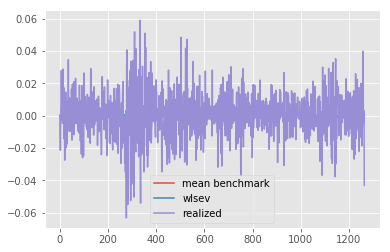

OLS Estimation Results
Forecast Horizon: 1
-------------------------------------------------------------------------------------------------------
betas: [-0.0001 -0.037 ]
robust bse standard errors: [ 0.0002  0.0202]
t-stats: [-0.4508 -1.8281]
In sample R_squared: 0.0014
Out of sample R_squared: 0.0033
-------------------------------------------------------------------------------------------------------


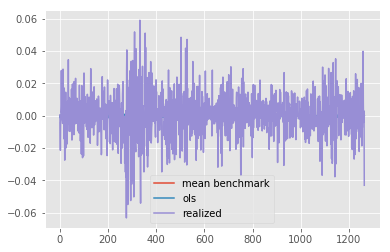

Simon's OLS Evaluation
-------------------------------------------------------------------------------------------------------
OLS betas: [[-0.00010296]
 [-0.03697201]]
OLS betas standard errors: [[ 0.00022546]
 [ 0.02003809]]
In sample R_squared: 0.0014
Out of sample R_squared: -0.0045
-------------------------------------------------------------------------------------------------------


In [8]:
# 2. least squares estimates weighted by ex-ante return variance (WLS-EV) using Johnson (2016)
# ------------------------------------------------------------------------------------------------------------

# set forecast_horizon
forecast_horizon = 1

# WLS-EV
wlsev_obj = Wlsev_model(wlsev_var_rets['logreturns'][:-1].as_matrix(), wlsev_var_rets['logreturns'][1:].as_matrix(), wlsev_var_rets['vol_daily_est'][:-1].as_matrix(), forecast_horizon)
wlsev_obj.fit()
# OOS evaluation to get Rsquared
wlsev_obj.evaluate()
wlsev_obj.print_results()
wlsev_obj.plot_results()

# OLS
ols_obj = OLS_model(wlsev_var_rets['logreturns'][:-1].as_matrix(), wlsev_var_rets['logreturns'][1:].as_matrix(), forecast_horizon)
ols_obj.fit()
# OOS evaluation to get Rsquared
ols_obj.evaluate()
ols_obj.print_results()
ols_obj.plot_results()

# Get Simon's OLS estimation results
if forecast_horizon == 1:
    ols_model = OLS(wlsev_var_rets['logreturns'][:-1].as_matrix(), wlsev_var_rets['logreturns'][1:].as_matrix())
    ols_model.fit()
    ols_model.printResults()

##### Forecast Horizon 5

WLS-EV Estimation Results
Forecast Horizon: 5
-------------------------------------------------------------------------------------------------------
betas: [-0.0003 -0.1059]
robust bse standard errors: [ 0.0008  0.0329]
t-stats: [-0.3961 -3.2214]
In sample R_squared: 0.0052
Out of sample R_squared: 0.0055
-------------------------------------------------------------------------------------------------------


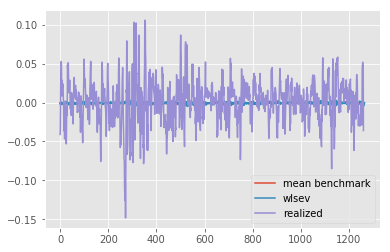

OLS Estimation Results
Forecast Horizon: 5
-------------------------------------------------------------------------------------------------------
betas: [-0.0005 -0.1589]
robust bse standard errors: [ 0.001   0.0428]
t-stats: [-0.4858 -3.7155]
In sample R_squared: 0.0059
Out of sample R_squared: 0.0045
-------------------------------------------------------------------------------------------------------


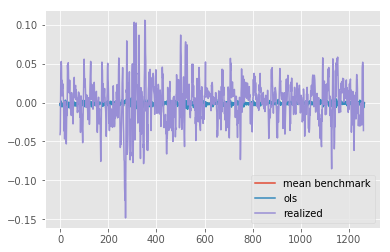

In [9]:
# 2. least squares estimates weighted by ex-ante return variance (WLS-EV) using Johnson (2016)
# ------------------------------------------------------------------------------------------------------------

# set forecast_horizon
forecast_horizon = 5

# WLS-EV
wlsev_obj = Wlsev_model(wlsev_var_rets['logreturns'][:-1].as_matrix(), wlsev_var_rets['logreturns'][1:].as_matrix(), wlsev_var_rets['vol_daily_est'][:-1].as_matrix(), forecast_horizon)
wlsev_obj.fit()
# OOS evaluation to get Rsquared
wlsev_obj.evaluate()
wlsev_obj.print_results()
wlsev_obj.plot_results()

# OLS
ols_obj = OLS_model(wlsev_var_rets['logreturns'][:-1].as_matrix(), wlsev_var_rets['logreturns'][1:].as_matrix(), forecast_horizon)
ols_obj.fit()
# OOS evaluation to get Rsquared
ols_obj.evaluate()
ols_obj.print_results()
ols_obj.plot_results()

##### Forecast Horizon 10

WLS-EV Estimation Results
Forecast Horizon: 10
-------------------------------------------------------------------------------------------------------
betas: [-0.0007 -0.0855]
robust bse standard errors: [ 0.0014  0.0451]
t-stats: [-0.4989 -1.8973]
In sample R_squared: 0.0027
Out of sample R_squared: 0.0058
-------------------------------------------------------------------------------------------------------


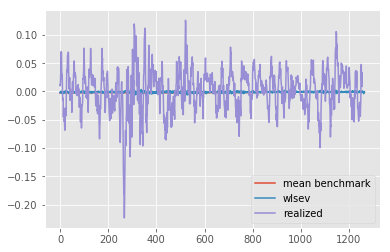

OLS Estimation Results
Forecast Horizon: 10
-------------------------------------------------------------------------------------------------------
betas: [-0.001  -0.1661]
robust bse standard errors: [ 0.0016  0.057 ]
t-stats: [-0.6252 -2.916 ]
In sample R_squared: 0.0035
Out of sample R_squared: -0.0001
-------------------------------------------------------------------------------------------------------


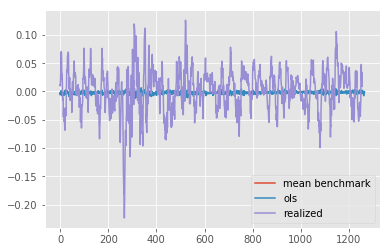

In [10]:
# 2. least squares estimates weighted by ex-ante return variance (WLS-EV) using Johnson (2016)
# ------------------------------------------------------------------------------------------------------------

# set forecast_horizon
forecast_horizon = 10

# WLS-EV
wlsev_obj = Wlsev_model(wlsev_var_rets['logreturns'][:-1].as_matrix(), wlsev_var_rets['logreturns'][1:].as_matrix(), wlsev_var_rets['vol_daily_est'][:-1].as_matrix(), forecast_horizon)
wlsev_obj.fit()
# OOS evaluation to get Rsquared
wlsev_obj.evaluate()
wlsev_obj.print_results()
wlsev_obj.plot_results()

# OLS
ols_obj = OLS_model(wlsev_var_rets['logreturns'][:-1].as_matrix(), wlsev_var_rets['logreturns'][1:].as_matrix(), forecast_horizon)
ols_obj.fit()
# OOS evaluation to get Rsquared
ols_obj.evaluate()
ols_obj.print_results()
ols_obj.plot_results()

### Regress returns on VRP

##### Join vrp data with wls-ev log rets and ex ante variance

In [11]:
es_50_vrp_rets_var = wlsev_var_rets.join(es_50_vrp).dropna()

##### forecast horizon 1

WLS-EV Estimation Results
Forecast Horizon: 1
-------------------------------------------------------------------------------------------------------
betas: [-0.0109  0.24  ]
robust bse standard errors: [ 0.0008  0.0532]
t-stats: [-12.9158   4.5107]
In sample R_squared: -0.0517
Out of sample R_squared: -0.0706
-------------------------------------------------------------------------------------------------------


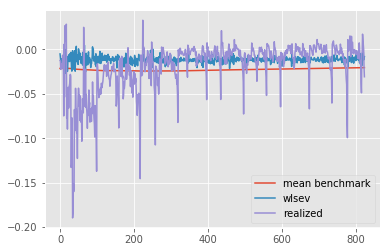

OLS Estimation Results
Forecast Horizon: 1
-------------------------------------------------------------------------------------------------------
betas: [-0.0205  0.4095]
robust bse standard errors: [ 0.0016  0.1142]
t-stats: [-13.1779   3.5872]
In sample R_squared: 0.0286
Out of sample R_squared: -0.0162
-------------------------------------------------------------------------------------------------------
Simon's OLS Evaluation
-------------------------------------------------------------------------------------------------------
OLS betas: [[-0.02049253]
 [ 0.40951702]]
OLS betas standard errors: [[ 0.00170784]
 [ 0.11998308]]
In sample R_squared: 0.0286
Out of sample R_squared: -0.1326
-------------------------------------------------------------------------------------------------------


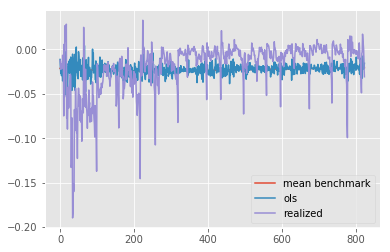

In [12]:
# set forecast_horizon
forecast_horizon = 1

# WLS-EV
wlsev_obj = Wlsev_model(es_50_vrp_rets_var['logreturns'][:-1].as_matrix(), es_50_vrp_rets_var['vrp'][1:].as_matrix(), es_50_vrp_rets_var['vol_daily_est'][:-1].as_matrix(), forecast_horizon)
wlsev_obj.fit()
# OOS evaluation to get Rsquared
wlsev_obj.evaluate()
wlsev_obj.print_results()
wlsev_obj.plot_results()

# OLS
ols_obj = OLS_model(es_50_vrp_rets_var['logreturns'][:-1].as_matrix(), es_50_vrp_rets_var['vrp'][1:].as_matrix(), forecast_horizon)
ols_obj.fit()
# OOS evaluation to get Rsquared
ols_obj.evaluate()
ols_obj.print_results()

# Get Simon's OLS estimation results
if forecast_horizon == 1:
    ols_model = OLS(es_50_vrp_rets_var['logreturns'][:-1].as_matrix(), es_50_vrp_rets_var['vrp'][1:].as_matrix())
    ols_model.fit()
    ols_model.printResults()
    ols_obj.plot_results()

##### forecast horizon 5

WLS-EV Estimation Results
Forecast Horizon: 5
-------------------------------------------------------------------------------------------------------
betas: [-0.0493  0.6216]
robust bse standard errors: [ 0.0037  0.1776]
t-stats: [-13.1625   3.4994]
In sample R_squared: -0.1151
Out of sample R_squared: -0.1183
-------------------------------------------------------------------------------------------------------


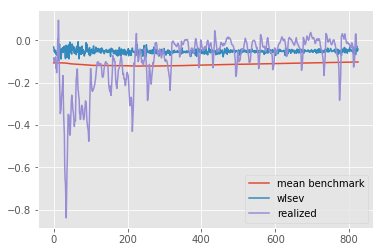

OLS Estimation Results
Forecast Horizon: 5
-------------------------------------------------------------------------------------------------------
betas: [-0.1025  0.8479]
robust bse standard errors: [ 0.0077  0.3619]
t-stats: [-13.3091   2.3425]
In sample R_squared: 0.0063
Out of sample R_squared: -0.0054
-------------------------------------------------------------------------------------------------------


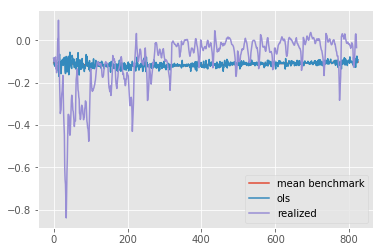

In [13]:
# set forecast_horizon
forecast_horizon = 5

# WLS-EV
wlsev_obj = Wlsev_model(es_50_vrp_rets_var['logreturns'][:-1].as_matrix(), es_50_vrp_rets_var['vrp'][1:].as_matrix(), es_50_vrp_rets_var['vol_daily_est'][:-1].as_matrix(), forecast_horizon)
wlsev_obj.fit()
# OOS evaluation to get Rsquared
wlsev_obj.evaluate()
wlsev_obj.print_results()
wlsev_obj.plot_results()

# OLS
ols_obj = OLS_model(es_50_vrp_rets_var['logreturns'][:-1].as_matrix(), es_50_vrp_rets_var['vrp'][1:].as_matrix(), forecast_horizon)
ols_obj.fit()
# OOS evaluation to get Rsquared
ols_obj.evaluate()
ols_obj.print_results()
ols_obj.plot_results()

##### forecast horizon 10

WLS-EV Estimation Results
Forecast Horizon: 10
-------------------------------------------------------------------------------------------------------
betas: [-0.0931  0.7984]
robust bse standard errors: [ 0.007   0.2513]
t-stats: [-13.3728   3.1767]
In sample R_squared: -0.1512
Out of sample R_squared: -0.1433
-------------------------------------------------------------------------------------------------------


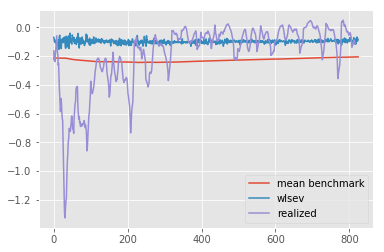

OLS Estimation Results
Forecast Horizon: 10
-------------------------------------------------------------------------------------------------------
betas: [-0.2054  1.0654]
robust bse standard errors: [ 0.0149  0.6866]
t-stats: [-13.769    1.5518]
In sample R_squared: 0.0029
Out of sample R_squared: -0.0024
-------------------------------------------------------------------------------------------------------


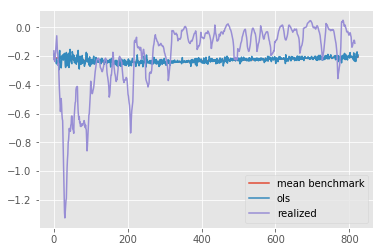

In [14]:
# set forecast_horizon
forecast_horizon = 10

# WLS-EV
wlsev_obj = Wlsev_model(es_50_vrp_rets_var['logreturns'][:-1].as_matrix(), es_50_vrp_rets_var['vrp'][1:].as_matrix(), es_50_vrp_rets_var['vol_daily_est'][:-1].as_matrix(), forecast_horizon)
wlsev_obj.fit()
# OOS evaluation to get Rsquared
wlsev_obj.evaluate()
wlsev_obj.print_results()
wlsev_obj.plot_results()

# OLS
ols_obj = OLS_model(es_50_vrp_rets_var['logreturns'][:-1].as_matrix(), es_50_vrp_rets_var['vrp'][1:].as_matrix(), forecast_horizon)
ols_obj.fit()
# OOS evaluation to get Rsquared
ols_obj.evaluate()
ols_obj.print_results()
ols_obj.plot_results()